# Trading Gamma

Trading gamma involves continuous delta hedging to maintain delta neutrality.

Black Scholes PDE: $rP_{t} = \theta + \big(r-q\big)S_{t}\delta + \frac{1}{2} \gamma S_{t}^{2} \sigma^{2}$\
With Delta Hedging, $\delta = 0$ and if $r = 0$, the PDE reduces to $\theta = - \frac{1}{2} \gamma S_{t}^{2}\sigma^{2}$ \
Profit = $\frac{1}{2} \gamma S^{2}   \big(\sigma^{2}- \Sigma ^{2}\big) dt$ 

By dynamically hedging against directional risk, traders are making a bet on volatility. As a result, profit is achieved if realized volatility is higher than implied volatility

In [1]:
import pandas as pd
import numpy as np
from typing import Optional
from scipy.stats import norm
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Black Scholes Call & Delta

In [2]:
class BlackScholes:
        def __init__(
        self,
        S: float, 
        K: int, 
        r: float, 
        sigma: float, 
        T: float
        ):
                '''
                S = spot
                K = strike
                r = risk-free rate
                sigma = vol
                T = time to maturity
                '''
                self.S = S 
                self.K = K
                self.r = r
                self.sigma = sigma 
                self.T = T

        def BlackScholesCall(self) -> float:
                d1 = (np.log(self.S / self.K) + (self.r + self.sigma ** 2 / 2) * self.T) / (self.sigma * np.sqrt(self.T))
                d2 = d1 - self.sigma * np.sqrt(self.T)
                return self.S * norm.cdf(d1) - self.K * np.exp(-self.r * self.T) * norm.cdf(d2)

        def calldelta(self) -> float:
                '''
                compute call delta  N(d1)
                '''
                d1 = (np.log(self.S / self.K) + (self.r + self.sigma ** 2 / 2) * self.T) / (self.sigma * np.sqrt(self.T))
                return norm.cdf(d1)

# Simulation

In [3]:
class simulate:
        def __init__(
        self,
        S_0: float,
        strike: int,
        r: float, 
        sigma: float, 
        realized_vol: float
        ) -> None:
                '''
                S_0 = spot
                strike = strike price
                r = risk-free rate
                sigma = volatility
                '''
                self.S_0 = S_0
                self.strike = strike
                self.r = r
                self.sigma = sigma 
                self.realized_vol = realized_vol
                
        def compute_pnl(
                self,
                S: list[float],
                option_price: float,
                option_delta: float
        ) -> tuple[list[float], list[float], list[float]]:
                
                # change in option price
                option_pnl = np.diff(option_price)
                option_pnl = np.pad(option_pnl, (1, 0), mode='constant', constant_values = 0)

                # change in hedge stock pnl
                hedge_pnl = np.diff(S) * -option_delta[:-1]
                hedge_pnl = np.pad(hedge_pnl, (1, 0), mode='constant', constant_values=0)

                # total pnl
                total_pnl = option_pnl + hedge_pnl

                return option_pnl, hedge_pnl, total_pnl

        def generate_stock_price(
                self,
                dt: float, 
                num_steps: int
        ) -> list[float]: 
                
                # brownian motion
                x = np.random.normal(0, 1.0, num_steps)  

                # drift and diffusion     
                vol_sqrt_dt = self.realized_vol * np.sqrt(dt)
                drift = (self.r - 0.5 * self.realized_vol * self.realized_vol) * dt    
                
                path = np.zeros(num_steps + 1)
                path[0] = np.log(self.S_0)    
                for i in range(1, num_steps + 1):
                        path[i] = path[i - 1] + drift + vol_sqrt_dt * x[i - 1]        
                        
                return np.exp(path)

        def compute_simulation_pnl(
                self,
                n: int,
                dt: float, 
                num_steps: int,
                option_maturity: float
        ):
                all_pnl = np.zeros(n)
                for i in range(n):
                        path = self.generate_stock_price(dt, num_steps)

                        # compute option price
                        option_price = np.zeros(len(path))
                        option_delta = np.zeros(len(path))
                        ttm = np.arange(0, option_maturity, option_maturity / num_steps)[::-1]
                        for j in range(0, len(path)-1):
                                option = BlackScholes(path[j], self.strike, self.r, self.sigma, ttm[j])
                                option_price[j] = option.BlackScholesCall()
                                option_delta[j] = option.calldelta()

                        _, _, total_pnl = self.compute_pnl(path, option_price, option_delta)

                        all_pnl[i] = total_pnl[:-1].sum()
                return all_pnl

# Illustrative Example
We are able to acheive a total PnL of $1.57 from Delta Hedging

In [4]:
spot = [100, 104.6, 99, 103.6, 99]
ttm = [1, 0.99, 0.98, 0.97, 0.96]
strike, risk_free, vol = 100, 0.0, 0.1
trading_book = {
    'TTM': ttm,
    'spot': spot
}

option_price = np.zeros(len(spot))
option_delta = np.zeros(len(spot))
sim = simulate(spot[0], strike, risk_free, vol, vol)

for i in range(0, len(spot)):
    option = BlackScholes(spot[i], strike, risk_free, vol, ttm[i])
    option_price[i] = option.BlackScholesCall()
    option_delta[i] = option.calldelta()

trading_book['option_pnl'], trading_book['hedge_pnl'], trading_book['total_pnl'] = sim.compute_pnl(spot, option_price, option_delta)
trading_book['option_price'] = option_price
trading_book['option_delta'] = option_delta

df = pd.DataFrame.from_dict(trading_book)
df[['TTM', 'spot', 'option_price', 'option_delta', 'option_pnl', 'hedge_pnl', 'total_pnl']]

,TTM,spot,option_price,option_delta,option_pnl,hedge_pnl,total_pnl
0,1.00,100.0,3.987761,0.519939,0.000000,0.000000,0.000000
1,0.99,104.6,6.766347,0.692078,2.778586,-2.391719,0.386867
2,0.98,99.0,3.448185,0.479254,-3.318162,3.875636,0.557474
3,0.97,103.6,6.053050,0.658489,2.604865,-2.204568,0.400297
4,0.96,99.0,3.408139,0.478632,-2.644911,3.029050,0.384139


# Simulation

In [5]:
pnl = []
num_sims = 3000
num_steps = 120
# 30 Day Expiry
Option_Maturity = 30.0 / 365
dt = Option_Maturity / num_steps
realized_vol = [0.1, 0.2, 0.3, 0.4]

for rv in realized_vol:
    sim = simulate(100, strike, risk_free, vol, rv)
    pnl.append(sim.compute_simulation_pnl(num_sims, dt, num_steps, Option_Maturity))

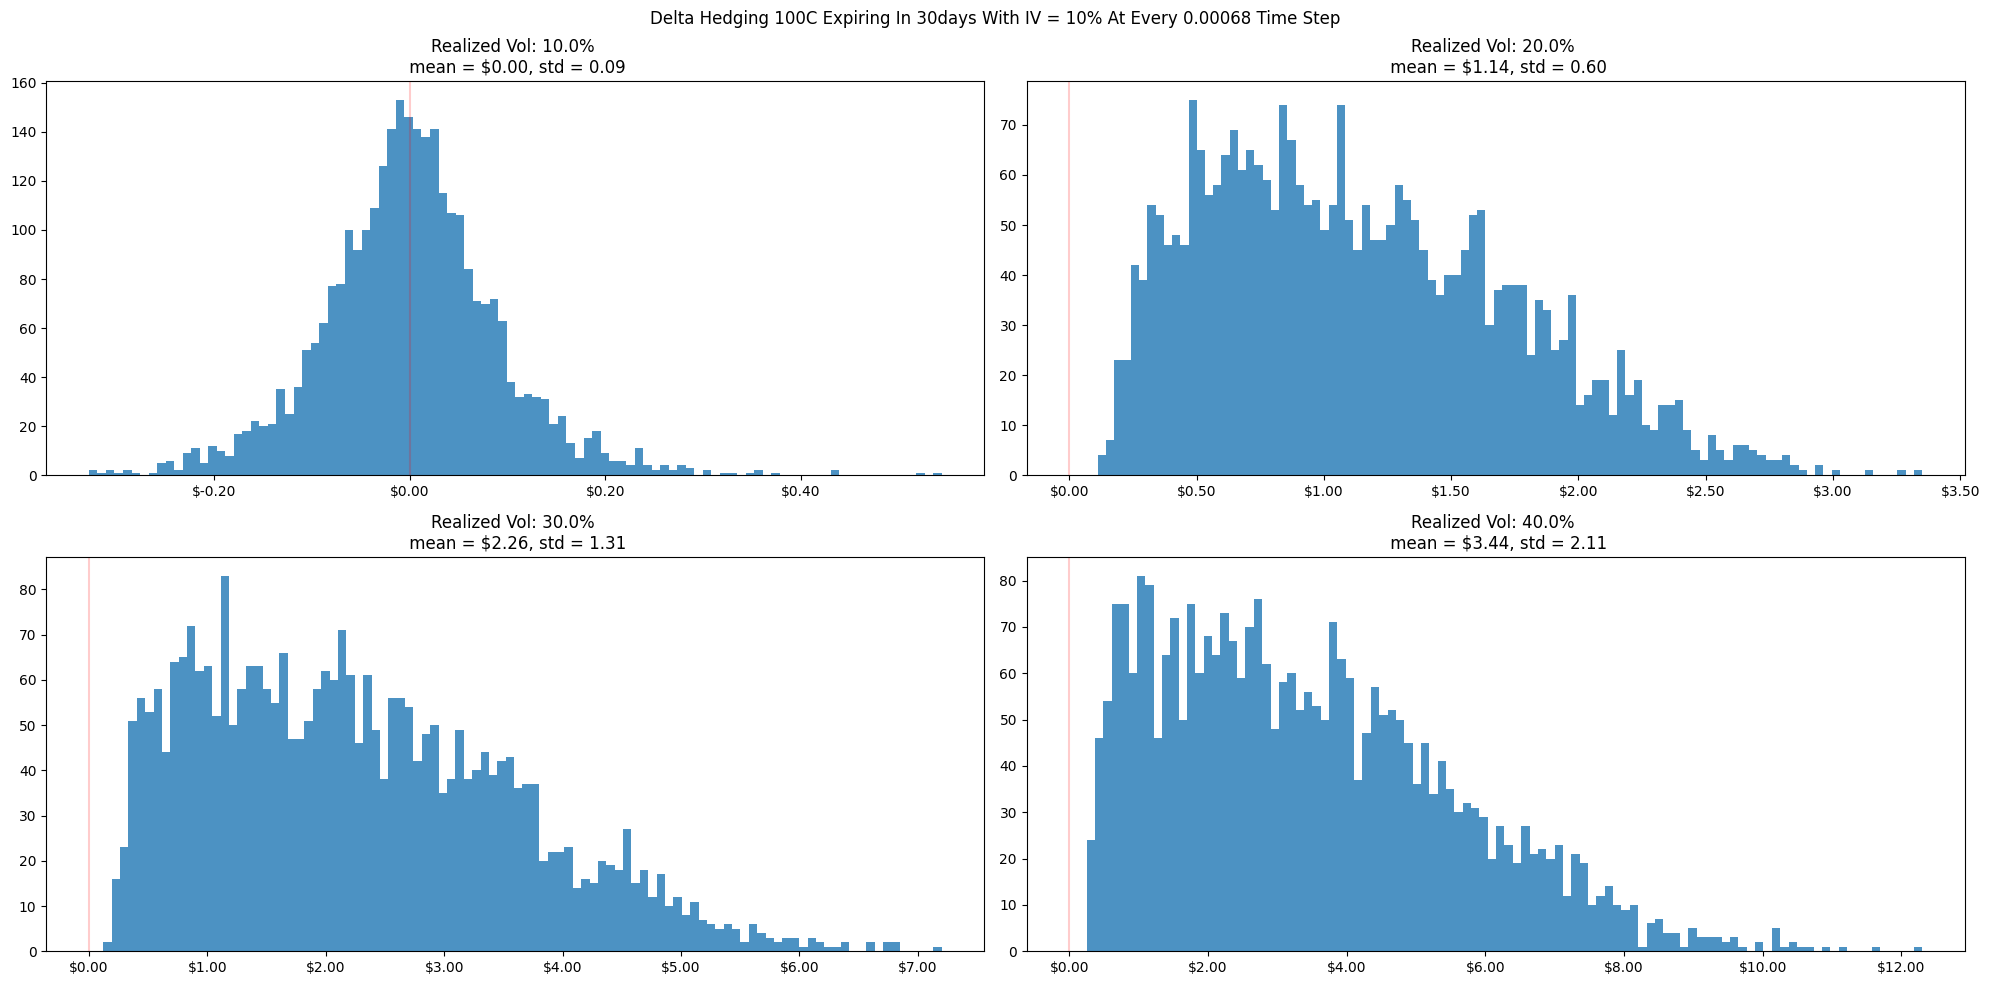

In [6]:
fig, axs = plt.subplots(2, 2, tight_layout = True, figsize = (20,10))
for i, ax in enumerate(axs.flatten()):
    mean = pnl[i].mean()
    std = pnl[i].std()
    ax.set_title(f'Realized Vol: {realized_vol[i] * 100}% \n mean = ${mean:,.2f}, std = {std:,.2f}')
    ax.axvline(x = 0, color = 'red', alpha = 0.2)
    ax.hist(pnl[i], bins = 100, alpha = 0.8)
    ax.xaxis.set_major_formatter('${x:1.2f}')
plt.suptitle(f'Delta Hedging 100C Expiring In 30days With IV = 10% At Every {round(dt,5)} Time Step');